## 6.1 Flavors of BERT

In [1]:
from transformers import pipeline

In [2]:
nlp = pipeline("fill-mask", model='bert-base-cased')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'transformers.models.bert.modeling_bert.BertForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:look. Score: 51.35%
Token:stop. Score: 39.66%
Token:glance. Score: 1.02%
Token:wait. Score: 0.60%
Token:turn. Score: 0.57%


In [3]:
nlp = pipeline("fill-mask", model='roberta-base')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:Ġlook. Score: 47.69%
Token:Ġstop. Score: 36.82%
Token:Ġstand. Score: 2.54%
Token:Ġstay. Score: 2.52%
Token:Ġwave. Score: 1.01%


In [4]:
nlp = pipeline("fill-mask", model='distilroberta-base')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:Ġstop. Score: 42.11%
Token:Ġlook. Score: 7.53%
Token:Ġpark. Score: 4.92%
Token:Ġarrive. Score: 4.65%
Token:Ġsign. Score: 4.27%


In [5]:
nlp = pipeline("fill-mask", model='distilbert-base-cased')  # Using a flavor of BERT called DistilBERT

print(type(nlp.model))  

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:look. Score: 57.47%
Token:stop. Score: 7.37%
Token:glance. Score: 3.74%
Token:arrive. Score: 2.16%
Token:appear. Score: 1.87%


## 6.2 BERT for sequence classification


In [6]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
     DataCollatorWithPadding, pipeline
from datasets import load_metric, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [7]:
!head snips.train.txt

listen O
to O
westbam B-artist
alumb O
allergic B-album
on O
google B-service
music I-service
PlayMusic



In [8]:
snips_file = open('./snips.train.txt', 'rb')

snips_rows = snips_file.readlines()

snips_rows[:20]

[b'listen O\n',
 b'to O\n',
 b'westbam B-artist\n',
 b'alumb O\n',
 b'allergic B-album\n',
 b'on O\n',
 b'google B-service\n',
 b'music I-service\n',
 b'PlayMusic\n',
 b'\n',
 b'add O\n',
 b'step B-entity_name\n',
 b'to I-entity_name\n',
 b'me I-entity_name\n',
 b'to O\n',
 b'the O\n',
 b'50 B-playlist\n',
 b'cl\xc3\xa1sicos I-playlist\n',
 b'playlist O\n',
 b'AddToPlaylist\n']

In [9]:
# This code segment parses the snips dataset into a more manageable format

utterances = []
tokenized_utterances = []
labels_for_tokens = []
sequence_labels = []

utterance, tokenized_utterance, label_for_utterances = '', [], []
for snip_row in snips_rows:
    if len(snip_row) == 2:  # skip over rows with no data
        continue
    if ' ' not in snip_row.decode():  # we've hit a sequence label
        sequence_labels.append(snip_row.decode().strip())
        utterances.append(utterance.strip())
        tokenized_utterances.append(tokenized_utterance)
        labels_for_tokens.append(label_for_utterances)
        utterance = ''
        tokenized_utterance = []
        label_for_utterances = []
        continue
    token, token_label = snip_row.decode().split(' ')
    token_label = token_label.strip()
    utterance += f'{token} '
    tokenized_utterance.append(token)
    label_for_utterances.append(token_label)
    

In [10]:
len(labels_for_tokens), len(tokenized_utterances), len(utterances), len(sequence_labels)

(26167, 26167, 26167, 26167)

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [12]:
unique_sequence_labels = list(set(sequence_labels))
unique_sequence_labels

['',
 'PlayMusic',
 'SearchCreativeWork',
 'GetWeather',
 'SearchScreeningEvent',
 'AddToPlaylist',
 'RateBook',
 'BookRestaurant']

In [13]:
sequence_labels = [unique_sequence_labels.index(l) for l in sequence_labels]

print(f'There are {len(unique_sequence_labels)} unique sequence labels')

There are 8 unique sequence labels


In [21]:
from functools import reduce

unique_token_labels = list(set(reduce(lambda x, y: x + y, labels_for_tokens)))
labels_for_tokens = [[unique_token_labels.index(_) for _ in l] for l in labels_for_tokens]

print(f'There are {len(unique_token_labels)} unique token labels')

There are 72 unique token labels


In [22]:
print(tokenized_utterances[0])
print(labels_for_tokens[0])
print([unique_token_labels[l] for l in labels_for_tokens[0]])
print(utterances[0])
print(sequence_labels[0])
print(unique_sequence_labels[sequence_labels[0]])

['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music']
[25, 25, 27, 25, 28, 25, 34, 22]
[25, 25, 27, 25, 28, 25, 34, 22]
listen to westbam alumb allergic on google music
1
PlayMusic


In [16]:
snips_dataset = Dataset.from_dict(
    dict(
        utterance=utterances, 
        label=sequence_labels,
        tokens=tokenized_utterances,
        token_labels=labels_for_tokens
    )
)
snips_dataset = snips_dataset.train_test_split(test_size=0.2)

In [17]:
snips_dataset['train'][1]

{'utterance': 'in 1 second i need a restaurant in san marino for 9',
 'label': 7,
 'tokens': ['in',
  '1',
  'second',
  'i',
  'need',
  'a',
  'restaurant',
  'in',
  'san',
  'marino',
  'for',
  '9'],
 'token_labels': [44, 4, 4, 25, 25, 25, 36, 25, 50, 3, 25, 49]}

In [18]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["utterance"], truncation=True)

In [19]:
seq_clf_tokenized_snips = snips_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/20933 [00:00<?, ? examples/s]

Map:   0%|          | 0/5234 [00:00<?, ? examples/s]

In [20]:
seq_clf_tokenized_snips['train'][0]

{'utterance': 'add to my playlist lazy chill afternoon nothing can stop us',
 'label': 5,
 'tokens': ['add',
  'to',
  'my',
  'playlist',
  'lazy',
  'chill',
  'afternoon',
  'nothing',
  'can',
  'stop',
  'us'],
 'token_labels': [25, 25, 14, 25, 70, 40, 40, 67, 8, 8, 8],
 'input_ids': [101,
  5194,
  1106,
  1139,
  1505,
  7276,
  16688,
  11824,
  4427,
  1720,
  1169,
  1831,
  1366,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [34]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [35]:
# Data Collator will pad data so that all examples are the same input length.
#  Attention mask is how we ignore attention scores for padding tokens

In [36]:
sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

# set an index -> label dictionary
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [37]:
sequence_clf_model.config.id2label[1]

'PlayMusic'

In [38]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [39]:
import logging

# Set the logging level
logging.basicConfig(level=logging.INFO)

train_dataset_size = len(seq_clf_tokenized_snips['train'])
batch_size = 32  # This should be your actual batch size per device
steps_per_epoch = train_dataset_size // batch_size

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    warmup_steps=steps_per_epoch // 5,  # number of warmup steps for learning rate scheduler
    weight_decay=0.05,
    logging_steps=1,
    evaluation_strategy='epoch',
    eval_steps=50,
    save_steps=steps_per_epoch  # Save at the end of each epoch
)
# Assume the rest of your definitions (model, data_collator, etc.) are correctly defined above.

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


In [40]:
# Get initial metrics
trainer.evaluate()

{'eval_loss': 2.1448607444763184,
 'eval_accuracy': 0.07737867787542989,
 'eval_runtime': 54.3648,
 'eval_samples_per_second': 96.275}

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.003100,0.023414,0.993313,74.077100,70.656000
2,0.000700,0.024112,0.993886,71.189600,73.522000


TrainOutput(global_step=1310, training_loss=0.11484244197232912, metrics={'train_runtime': 2482.4207, 'train_samples_per_second': 0.528, 'total_flos': 365421482511360, 'epoch': 2.0})

In [42]:
trainer.evaluate()

{'eval_loss': 0.02341417223215103,
 'eval_accuracy': 0.9933129537638518,
 'eval_runtime': 73.0449,
 'eval_samples_per_second': 71.655,
 'epoch': 2.0}

In [44]:
pipe = pipeline("sentiment-analysis", sequence_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'label': 'AddToPlaylist', 'score': 0.9994660019874573}]

In [45]:
trainer.save_model()

In [48]:
pipe = pipeline("sentiment-analysis", "./snips_clf/results", tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'label': 'AddToPlaylist', 'score': 0.998703122138977}]

In [49]:
frozen_sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [50]:
for param in frozen_sequence_clf_model.distilbert.parameters():
    param.requires_grad = False

In [54]:
epochs = 2
training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    warmup_steps=steps_per_epoch // 5,  # number of warmup steps for learning rate scheduler
    weight_decay=0.05,
    logging_steps=1,
    evaluation_strategy='epoch',
    eval_steps=50,
    save_steps=steps_per_epoch  # Save at the end of each epoch
)
# Assume the rest of your definitions (model, data_collator, etc.) are correctly defined above.

# Define the trainer:

trainer = Trainer(
    model=frozen_sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.
W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


In [55]:
trainer.evaluate()

{'eval_loss': 2.1084353923797607,
 'eval_accuracy': 0.07508597630875048,
 'eval_runtime': 47.2123,
 'eval_samples_per_second': 110.861}

In [56]:
trainer.train()  # ~23min -> ~6min on my laptop with all of distilbert frozen with a worse loss/accuracy

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.860300,0.560359,0.930264,67.375000,77.685000
2,0.099400,0.409285,0.951471,70.897200,73.825000


TrainOutput(global_step=1310, training_loss=0.7485144596802824, metrics={'train_runtime': 738.1337, 'train_samples_per_second': 1.775, 'total_flos': 365421482511360, 'epoch': 2.0})

In [57]:
trainer.evaluate()

{'eval_loss': 0.409284770488739,
 'eval_accuracy': 0.9514711501719526,
 'eval_runtime': 69.2081,
 'eval_samples_per_second': 75.627,
 'epoch': 2.0}

## 6.3 BERT for token classification

In [58]:
from transformers import DataCollatorForTokenClassification, DistilBertForTokenClassification, \
                         DistilBertTokenizerFast, pipeline

In [59]:
# using a cased tokenizer because I think case will matter
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [60]:
snips_dataset['train'][0]

{'utterance': 'add to my playlist lazy chill afternoon nothing can stop us',
 'label': 5,
 'tokens': ['add',
  'to',
  'my',
  'playlist',
  'lazy',
  'chill',
  'afternoon',
  'nothing',
  'can',
  'stop',
  'us'],
 'token_labels': [25, 25, 14, 25, 70, 40, 40, 67, 8, 8, 8]}

In [61]:
# The given "token_labels" may not match up with the BERT wordpiece tokenization so
#  this function will map them to the tokenization that BERT uses
#  -100 is a reserved for labels where we do not want to calculate losses so BERT doesn't waste time
#  trying to predict tokens like CLS or SEP

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"token_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Set the special tokens to -100.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # CLS and SEP are labeled as -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [62]:
snips_dataset['train'][0]

{'utterance': 'add to my playlist lazy chill afternoon nothing can stop us',
 'label': 5,
 'tokens': ['add',
  'to',
  'my',
  'playlist',
  'lazy',
  'chill',
  'afternoon',
  'nothing',
  'can',
  'stop',
  'us'],
 'token_labels': [25, 25, 14, 25, 70, 40, 40, 67, 8, 8, 8]}

In [63]:
# map our dataset from sequence classification to be for token classification
tok_clf_tokenized_snips = snips_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/20933 [00:00<?, ? examples/s]

Map:   0%|          | 0/5234 [00:00<?, ? examples/s]

In [64]:
tok_clf_tokenized_snips['train'][0]

{'utterance': 'add to my playlist lazy chill afternoon nothing can stop us',
 'label': 5,
 'tokens': ['add',
  'to',
  'my',
  'playlist',
  'lazy',
  'chill',
  'afternoon',
  'nothing',
  'can',
  'stop',
  'us'],
 'token_labels': [25, 25, 14, 25, 70, 40, 40, 67, 8, 8, 8],
 'input_ids': [101,
  5194,
  1106,
  1139,
  1505,
  7276,
  16688,
  11824,
  4427,
  1720,
  1169,
  1831,
  1366,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 25, 25, 14, 25, -100, 70, 40, 40, 67, 8, 8, 8, -100]}

In [65]:
tok_clf_tokenized_snips['train'] = tok_clf_tokenized_snips['train'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips['test'] = tok_clf_tokenized_snips['test'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20933
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5234
    })
})

In [66]:
tok_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [67]:
tok_clf_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-cased', num_labels=len(unique_token_labels)
)

# Set our label dictionary
tok_clf_model.config.id2label = {i: l for i, l in enumerate(unique_token_labels)}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [68]:
tok_clf_model.config.id2label[0], tok_clf_model.config.id2label[1]

(0, 1)

In [70]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    warmup_steps=steps_per_epoch // 5,  # number of warmup steps for learning rate scheduler
    logging_steps=10,
    evaluation_strategy='epoch',
    eval_steps=50,
    save_steps=steps_per_epoch  # Save at the end of each epoch
)
# Assume the rest of your definitions (model, data_collator, etc.) are correctly defined above.

# Define the trainer:

trainer = Trainer(
    model=frozen_sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


In [72]:
trainer.evaluate()

{'eval_loss': 0.409284770488739,
 'eval_accuracy': 0.9514711501719526,
 'eval_runtime': 49.4839,
 'eval_samples_per_second': 105.772}

In [73]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.243800,0.213216,0.960451,72.264300,72.429000
2,0.167800,0.179031,0.965227,73.968800,70.760000


TrainOutput(global_step=1310, training_loss=0.2654997528964327, metrics={'train_runtime': 770.9428, 'train_samples_per_second': 1.699, 'total_flos': 364730712123360, 'epoch': 2.0})

In [74]:
trainer.evaluate()

{'eval_loss': 0.1790306270122528,
 'eval_accuracy': 0.965227359572029,
 'eval_runtime': 73.6744,
 'eval_samples_per_second': 71.042,
 'epoch': 2.0}

In [76]:
pipe = pipeline("ner", tok_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'word': 'Please',
  'score': 0.027198350057005882,
  'entity': 37,
  'index': 1,
  'start': 0,
  'end': 6},
 {'word': 'add',
  'score': 0.024076612666249275,
  'entity': 37,
  'index': 2,
  'start': 7,
  'end': 10},
 {'word': 'Here',
  'score': 0.024415116757154465,
  'entity': 64,
  'index': 3,
  'start': 11,
  'end': 15},
 {'word': 'We',
  'score': 0.025688957422971725,
  'entity': 64,
  'index': 4,
  'start': 16,
  'end': 18},
 {'word': 'Go',
  'score': 0.02504601702094078,
  'entity': 64,
  'index': 5,
  'start': 19,
  'end': 21},
 {'word': 'by',
  'score': 0.026233388110995293,
  'entity': 64,
  'index': 6,
  'start': 22,
  'end': 24},
 {'word': 'Di',
  'score': 0.0220949649810791,
  'entity': 37,
  'index': 7,
  'start': 25,
  'end': 27},
 {'word': '##sp',
  'score': 0.025229359045624733,
  'entity': 64,
  'index': 8,
  'start': 27,
  'end': 29},
 {'word': '##atch',
  'score': 0.027838239446282387,
  'entity': 37,
  'index': 9,
  'start': 29,
  'end': 33},
 {'word': 'to',
  'sc

In [77]:
pipe = pipeline("ner", tok_clf_model, tokenizer=tokenizer)
pipe('Rate the doog food 5 out of 5')

[{'word': 'Rate',
  'score': 0.03451903909444809,
  'entity': 37,
  'index': 1,
  'start': 0,
  'end': 4},
 {'word': 'the',
  'score': 0.02664942853152752,
  'entity': 64,
  'index': 2,
  'start': 5,
  'end': 8},
 {'word': 'do',
  'score': 0.02363862656056881,
  'entity': 64,
  'index': 3,
  'start': 9,
  'end': 11},
 {'word': '##og',
  'score': 0.03238973021507263,
  'entity': 64,
  'index': 4,
  'start': 11,
  'end': 13},
 {'word': 'food',
  'score': 0.027224943041801453,
  'entity': 37,
  'index': 5,
  'start': 14,
  'end': 18},
 {'word': '5',
  'score': 0.03654227405786514,
  'entity': 64,
  'index': 6,
  'start': 19,
  'end': 20},
 {'word': 'out',
  'score': 0.032032933086156845,
  'entity': 12,
  'index': 7,
  'start': 21,
  'end': 24},
 {'word': 'of',
  'score': 0.028461666777729988,
  'entity': 12,
  'index': 8,
  'start': 25,
  'end': 27},
 {'word': '5',
  'score': 0.030903268605470657,
  'entity': 64,
  'index': 9,
  'start': 28,
  'end': 29}]

## 6.4 BERT for question/answering

In [80]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [81]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

INFO:filelock:Lock 5471113072 acquired on /Users/ling/.cache/huggingface/transformers/e12f02d630da91a0982ce6db1ad595231d155a2b725ab106971898276d842ecc.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

INFO:filelock:Lock 5471113072 released on /Users/ling/.cache/huggingface/transformers/e12f02d630da91a0982ce6db1ad595231d155a2b725ab106971898276d842ecc.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
INFO:filelock:Lock 5454409440 acquired on /Users/ling/.cache/huggingface/transformers/475d46024228961ca8770cead39e1079f135fd2441d14cf216727ffac8d41d78.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

INFO:filelock:Lock 5454409440 released on /Users/ling/.cache/huggingface/transformers/475d46024228961ca8770cead39e1079f135fd2441d14cf216727ffac8d41d78.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
INFO:filelock:Lock 5451486160 acquired on /Users/ling/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d.lock


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

INFO:filelock:Lock 5451486160 released on /Users/ling/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d.lock
INFO:filelock:Lock 5468996128 acquired on /Users/ling/.cache/huggingface/transformers/1d959166dd7e047e57ea1b2d9b7b9669938a7e90c5e37a03961ad9f15eaea17f.fea64cd906e3766b04c92397f9ad3ff45271749cbe49829a079dd84e34c1697d.lock


Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

INFO:filelock:Lock 5468996128 released on /Users/ling/.cache/huggingface/transformers/1d959166dd7e047e57ea1b2d9b7b9669938a7e90c5e37a03961ad9f15eaea17f.fea64cd906e3766b04c92397f9ad3ff45271749cbe49829a079dd84e34c1697d.lock
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exa

In [83]:
qa_df = pd.read_csv('./qa.csv')

qa_df.shape

(29989, 5)

In [84]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [85]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [86]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [87]:
# only grab 4,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(4000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [88]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [89]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [90]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [93]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


{'eval_loss': 5.804353713989258,
 'eval_runtime': 1436.2112,
 'eval_samples_per_second': 0.557}

In [94]:
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,4.398100,4.297838,1798.862500,0.445000
2,4.166300,4.203326,1721.472200,0.465000


TrainOutput(global_step=200, training_loss=4.440203838348388, metrics={'train_runtime': 21355.2859, 'train_samples_per_second': 0.009, 'total_flos': 4605241883142528, 'epoch': 2.0})

In [95]:
# Q/A models are very large and take a long time to fine-tune

In [96]:
trainer.save_model()

In [97]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

Some weights of BertModel were not initialized from the model checkpoint at ./qa/results and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.12872670590877533, 'start': 15, 'end': 25, 'answer': 'California'}

In [99]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.002211325103417039,
 'start': 106,
 'end': 138,
 'answer': 'Berkeley and Sir George Carteret'}

In [100]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.0026065504644066095,
 'start': 342,
 'end': 378,
 'answer': 'ozdemirLearn the techniques and math'}

In [101]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

In [102]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924464821815491, 'start': 15, 'end': 25, 'answer': 'California'}

In [103]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.31145331263542175,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [104]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What survey led to the founding of Princeton?", princeton,
    return_tensors='pt'
)

In [105]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7519, -3.6147, -8.6238, -8.5794, -8.7563, -8.1872, -8.1031, -8.2268,
         -7.5512, -9.8327, -5.7519, -6.2746, -4.7469, -7.9981, -6.5231, -6.2942,
         -6.9675, -8.3130, -7.0369, -8.2833, -6.1628, -8.1123, -5.4992, -5.6526,
         -6.2636, -8.3655, -5.3692, -7.8447, -8.8567, -6.3198, -8.5963, -5.9721,
         -7.6135, -7.3562, -8.2679, -8.3762, -6.8817, -7.8090, -7.5480, -7.4207,
         -7.2773, -8.2750, -7.7374, -7.5004, -7.8319, -7.9563, -7.1041, -5.7036,
         -7.5340, -8.4661, -8.3033, -7.9716, -7.2749, -8.5451, -8.1295, -7.2359,
         -8.6795, -8.9292, -7.6118, -8.6576, -6.9020, -5.7518,  6.3959,  5.9311,
         -1.0083, -4.0455,  1.1958, -4.5241, -2.6724, -4.6225, -3.4796, -5.6253,
         -7.3676, -5.4171, -7.9947, -5.3715, -5.9689, -8.1691, -6.2237, -7.7371,
         -4.7933, -5.0089, -6.9667, -5.7007, -3.2038, -4.9603, -4.6802,  1.7422,
         -7.9737, -6.3608, -5.4654, -7.9430, -7.3093, -7

In [106]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

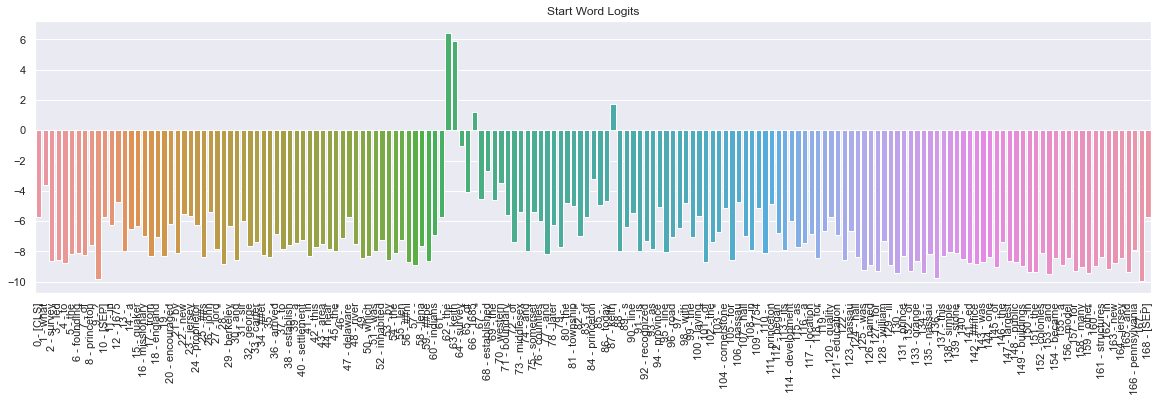

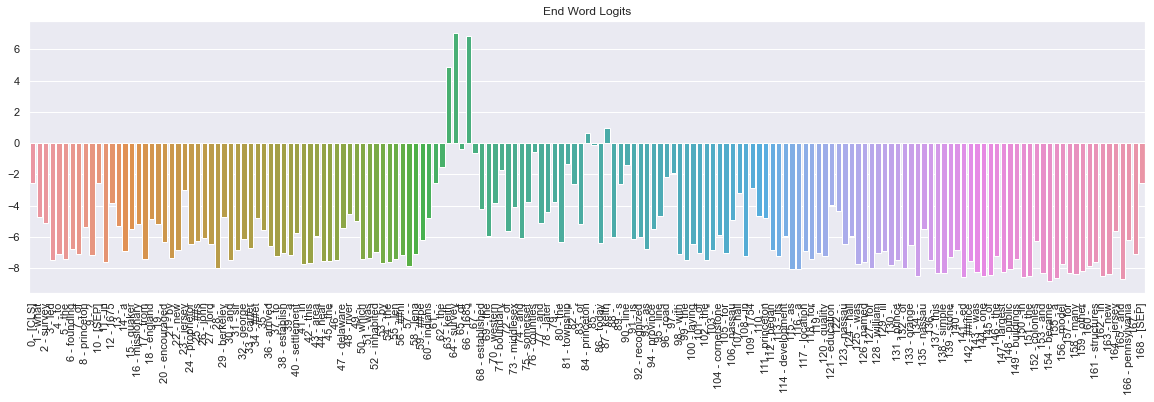

In [107]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()